In [1]:
# import kagglehub
# from scipy.io import loadmat
# import os
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Download latest version
# path = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")

# print("Path to dataset files:", path)

# # Collect all file names
# file_names = []
# for dirname, _, filenames in os.walk(path):
#     for filename in filenames:
#         file_names.append(os.path.join(dirname, filename))

# I. Data Preprocessing

In [2]:
import kagglehub
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

C:\Users\Administra\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## I.1. Extract and load the relevant EEG data channels (4-17) from the provided Matlab files

In [3]:
path = 'C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1'

# Collect all file names
file_names = []
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))

In [ ]:
# Khởi tạo danh sách để lưu trữ dữ liệu và nhãn từ tất cả các file
all_data = []

# Duyệt qua tất cả các file và trích xuất dữ liệu
for file_name in file_names:
    # Tải file .mat
    mat = loadmat(file_name)

    # Trích xuất dữ liệu từ đối tượng 'o'
    mdata = mat['o']

    # Truy cập vào 'sampFreq' và 'data'
    sampFreq = mdata['sampFreq'][0][0][0][0]  # Tần số lấy mẫu
    data = mdata['data'][0, 0]  # Dữ liệu EEG

    # Lọc dữ liệu từ các kênh 4-17 (kênh EEG)
    data_eeg = data[:, 3:17]

    # Lưu dữ liệu vào danh sách
    all_data.append(data_eeg)

In [ ]:
# In thử kích cỡ của file đầu tiên
all_data[0].shape

(308868, 14)

## I.2. Apply preprocess, normalize, scale, or any techniques to the data if you think it necessary for the task

### 1. Lọc băng thông và bộ lọc notch

In [7]:
from scipy.signal import butter, filtfilt, iirnotch

# Hàm tạo bộ lọc thông cao và thông thấp
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Hàm tạo bộ lọc notch
def notch_filter(data, notch_freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, data, axis=0)

# Lọc thông cao và thông thấp và lọc notch cho từng file
filtered_all_data = []
for data_eeg in all_data:
    # Lọc thông cao và thông thấp cho dữ liệu của file hiện tại
    lowcut = 0.5  # Hz
    highcut = 30  # Hz
    filtered_data_bandpass = bandpass_filter(data_eeg, lowcut, highcut, sampFreq)

    # Lọc notch để loại bỏ nhiễu 50 Hz cho dữ liệu đã lọc thông
    notch_freq = 50  # Hz
    filtered_data_notch = notch_filter(filtered_data_bandpass, notch_freq, sampFreq)

    # Lưu dữ liệu đã lọc vào danh sách
    filtered_all_data.append(filtered_data_notch)

In [13]:
# Kiểm tra kích thước của dữ liệu đầu tiên
print(filtered_all_data[0].shape)

(308868, 14)


### 2. Visualize data sau khi lọc

Dữ liệu từ file C:/Users/Administra/.cache/kagglehub/datasets/inancigdem/eeg-data-for-mental-attention-state-detection/versions/1\EEG Data\eeg_record1.mat: (388788, 25)


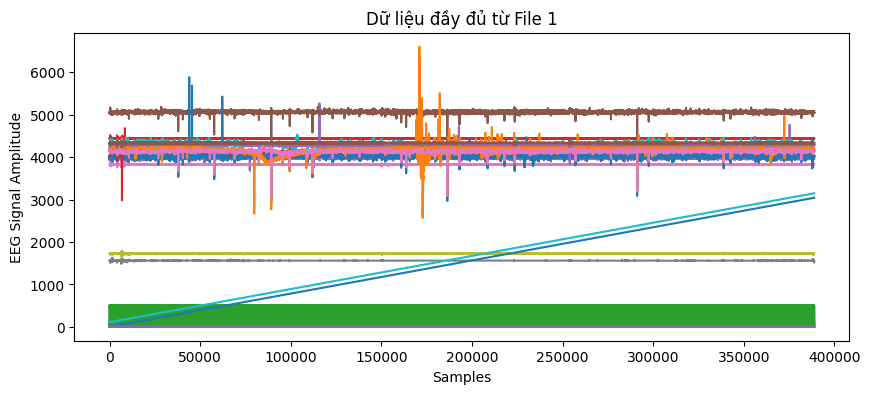


Dữ liệu EEG từ các kênh 4-17: (388788, 14)


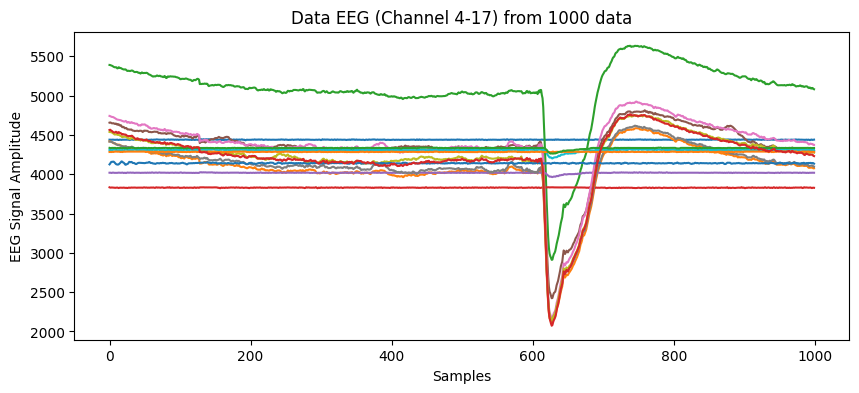

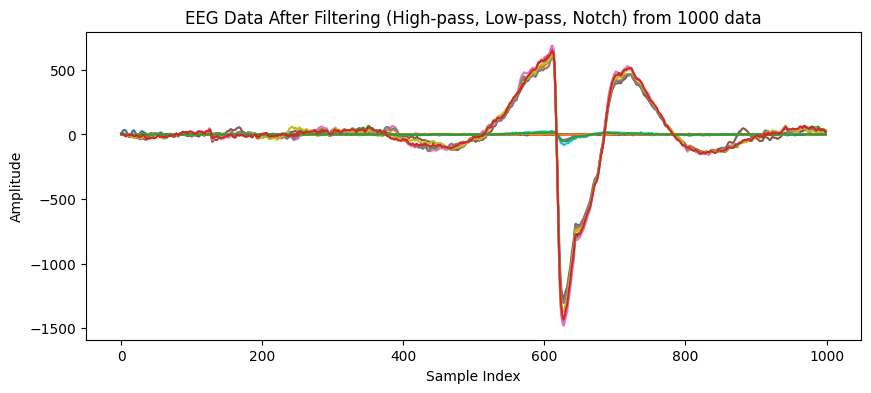

In [16]:
# Phân tích dữ liệu 
for i in range(1):
    print('Dữ liệu từ file {}:'.format(file_names[i]), data.shape)
    plt.figure(figsize=(10, 4))
    plt.plot(data)
    plt.title(f'Dữ liệu đầy đủ từ File {i + 1}')
    plt.xlabel('Samples')
    plt.ylabel('EEG Signal Amplitude')
    plt.show()

    print('\nDữ liệu EEG từ các kênh 4-17:', data_eeg.shape)
    plt.figure(figsize=(10, 4))
    plt.plot(all_data[0][:1000, :])
    plt.title(f'Data EEG (Channel 4-17) from 1000 data')
    plt.xlabel('Samples')
    plt.ylabel('EEG Signal Amplitude')
    plt.show()

    # Biểu diễn tín hiệu sau khi lọc của 1000 data đâu tiên
    plt.figure(figsize=(10, 4))
    plt.plot(filtered_all_data[0][:1000, :])  # Lấy 1000 mẫu từ file đầu tiên trong danh sách đã lọc
    plt.title('EEG Data After Filtering (High-pass, Low-pass, Notch) from 1000 data')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.show()


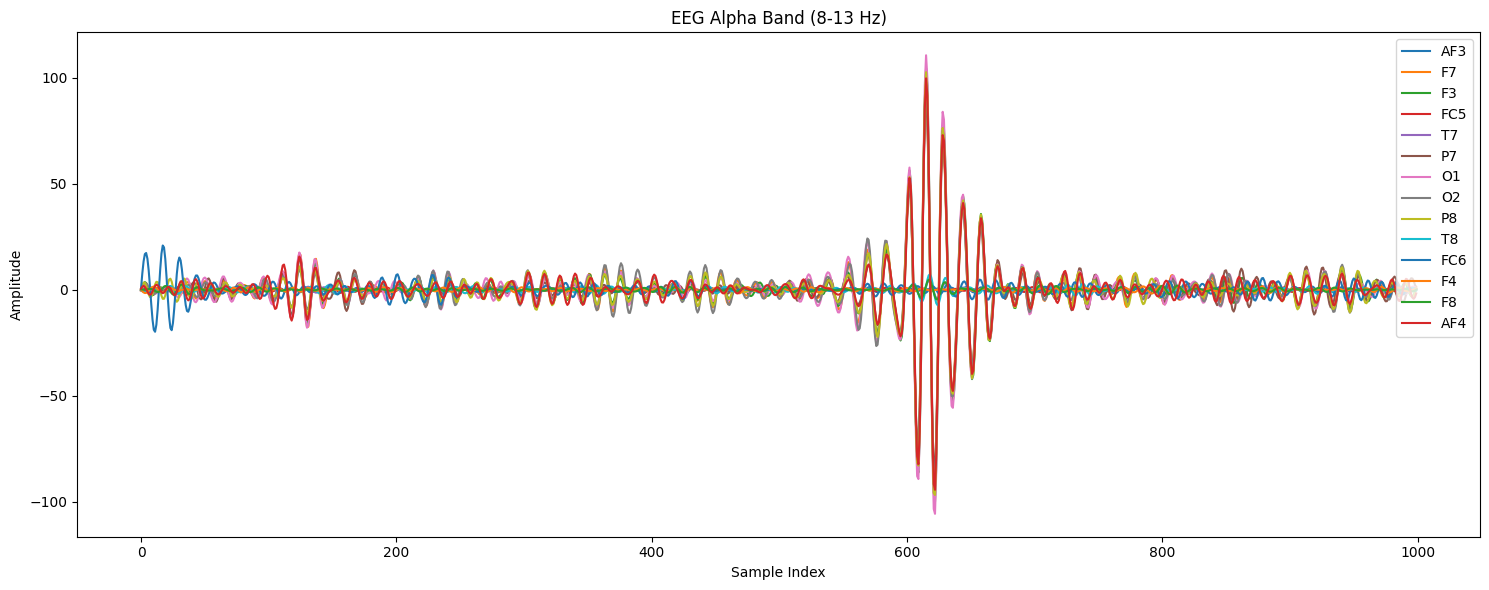

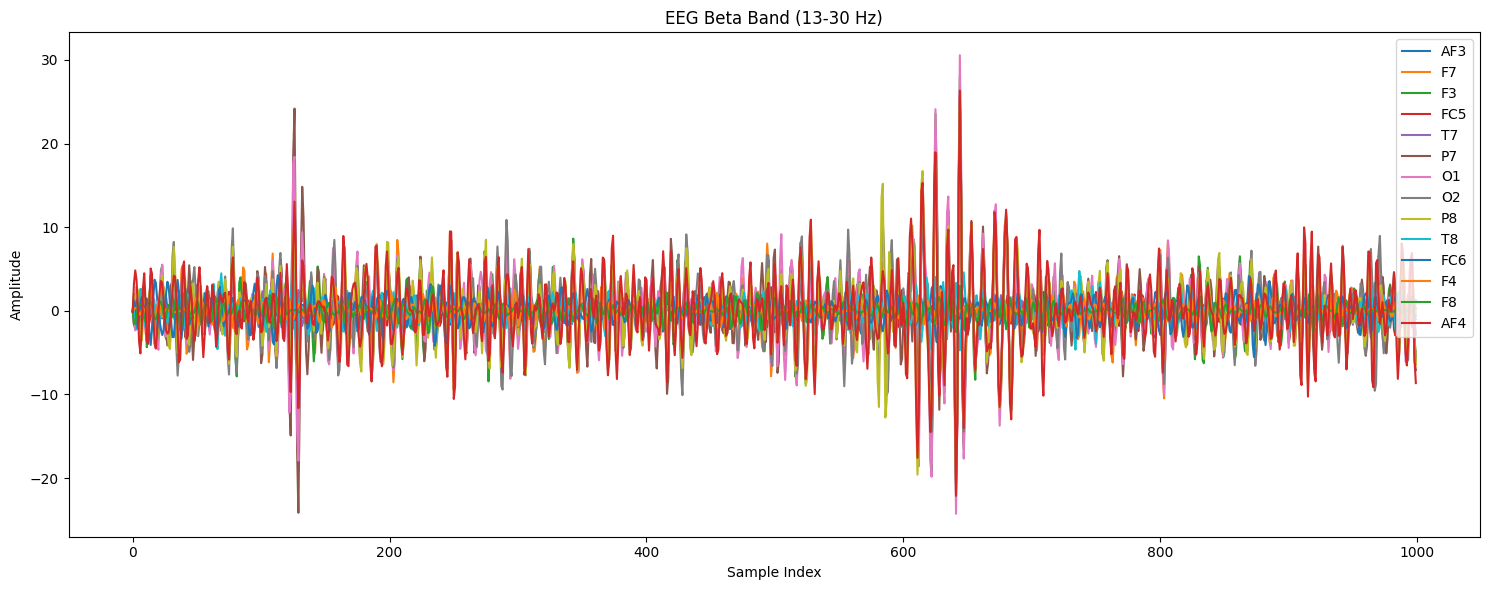

In [17]:
# BIỂU DIỄN TÍN HIỆU ALPHA VÀ BETA

# Lọc thông dải để giữ lại dải alpha (8-13 Hz) hoặc beta (13-30 Hz)
alpha_low = 8  # Hz
alpha_high = 13  # Hz
beta_low = 13  # Hz
beta_high = 30  # Hz

# Chọn dữ liệu từ file đầu tiên đã lọc để biểu diễn
filtered_0 = filtered_all_data[0]
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

alpha_band = bandpass_filter(filtered_0, alpha_low, alpha_high, sampFreq)
beta_band = bandpass_filter(filtered_0, beta_low, beta_high, sampFreq)

# Biểu diễn tín hiệu dải alpha
plt.figure(figsize=(15, 6))
plt.plot(alpha_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
plt.title('EEG Alpha Band (8-13 Hz)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend(channel_names, loc='upper right')
plt.tight_layout()
plt.show()

# Biểu diễn tín hiệu dải beta
plt.figure(figsize=(15, 6))
plt.plot(beta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
plt.title('EEG Beta Band (13-30 Hz)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend(channel_names, loc='upper right')
plt.tight_layout()
plt.show()

### 3. ICA

#### ICA with data original

ICA with 5 file đầu tiên (đại diện cho 1 người): giải thích output và chọn thành phần thì bàn sau

In [ ]:
import mne
from mne.preprocessing import ICA

# Gộp dữ liệu từ 5 file đầu tiên đã lọc
combined_7_file = np.concatenate(filtered_all_data[:6], axis=0)

# Tạo thông tin cho đối tượng Raw
sfreq = 128  # Tần số lấy mẫu (giả sử là 128 Hz, bạn có thể thay đổi nếu khác)
info = mne.create_info(sfreq=sfreq, ch_names=channel_names, ch_types='eeg')

# Lấy dữ liệu đã lọc từ danh sách, chuyển đổi thành dạng phù hợp cho MNE
filtered_data_mne = combined_7_file.T  # Chuyển thành (n_channels, n_times)

# Tạo đối tượng Raw từ dữ liệu
raw = mne.io.RawArray(filtered_data_mne, info)

# Thêm montage vào đối tượng Raw với montage 'standard_1020'
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, match_case=False)

# Áp dụng ICA để tách các thành phần độc lập
ica = ICA(n_components=14, random_state=42, max_iter='auto')
ica.fit(raw)

Creating RawArray with float64 data, n_channels=14, n_times=2157028
    Range : 0 ... 2157027 =      0.000 ... 16851.773 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_21212\4067292767.py:23: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 28.6s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,48 iterations on raw data (2157028 samples)
ICA components,14
Available PCA components,14
Channel types,eeg
ICA components marked for exclusion,—


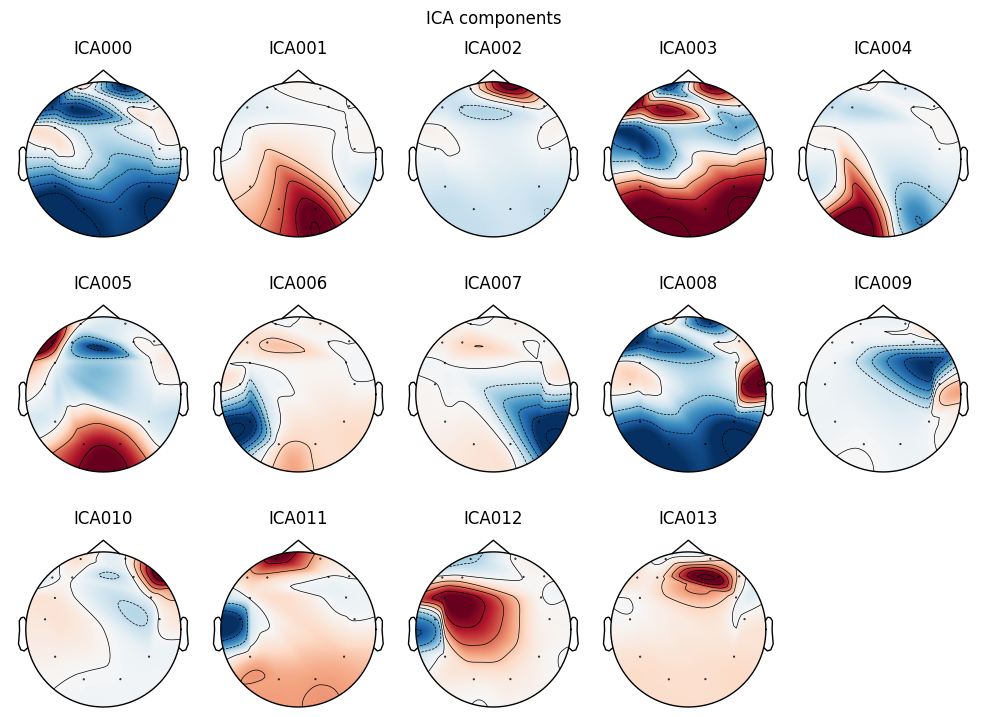

In [26]:
# Vẽ các thành phần độc lập
ica.plot_components()
plt.show()

Creating RawArray with float64 data, n_channels=14, n_times=2157028
    Range : 0 ... 2157027 =      0.000 ... 16851.773 secs
Ready.


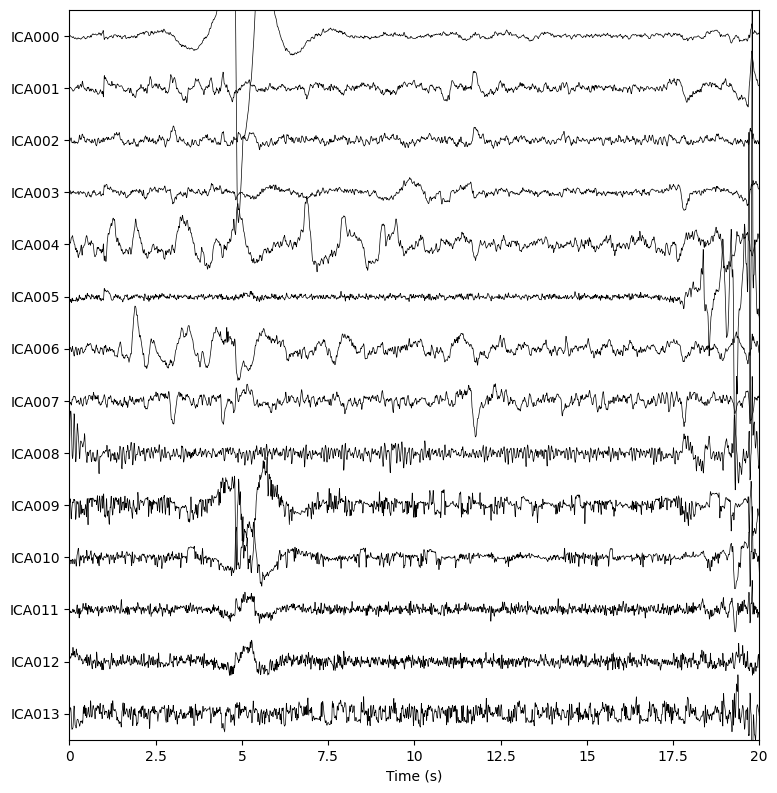

In [29]:
ica.plot_sources(raw, show_scrollbars=False)
plt.show()

In [43]:
# Gộp dữ liệu cho từng người và áp dụng ICA
start_index = 1  # Bắt đầu từ người thứ 2
ica_list = []
raw_list = []

for i in range(start_index, 5):
    if i == 4:
        combined_data = np.concatenate(filtered_all_data[i * 7 : i * 7 + 6], axis=0)  # Người thứ 5 có 6 lần đo
    else:
        combined_data = np.concatenate(filtered_all_data[i * 7 : i * 7 + 7], axis=0)  # Người còn lại có 7 lần đo

    # Tạo thông tin cho đối tượng Raw
    sfreq = 128  # Tần số lấy mẫu (giả sử là 128 Hz, bạn có thể thay đổi nếu khác)
    n_channels = combined_data.shape[1]
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')

    # Lấy dữ liệu đã lọc từ danh sách, chuyển đổi thành dạng phù hợp cho MNE
    filtered_data_mne = combined_data.T  # Chuyển thành (n_channels, n_times)

    # Tạo đối tượng Raw từ dữ liệu
    raw = mne.io.RawArray(filtered_data_mne, info)

    # Thêm montage vào đối tượng Raw với montage 'standard_1020'
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage)

    # Áp dụng ICA để tách các thành phần độc lập
    ica = ICA(n_components=14, random_state=42, max_iter='auto')
    ica.fit(raw)

    # Lưu ICA và Raw để sử dụng sau
    ica_list.append(ica)
    raw_list.append(raw)

    # In ra thông báo đã xử lý xong
    print(f'Đã áp dụng ICA cho dữ liệu của người thứ {i+1}')


Creating RawArray with float64 data, n_channels=14, n_times=2472532
    Range : 0 ... 2472531 =      0.000 ... 19316.648 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_21212\3736704171.py:29: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 36.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 2
Creating RawArray with float64 data, n_channels=14, n_times=2414264
    Range : 0 ... 2414263 =      0.000 ... 18861.430 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_21212\3736704171.py:29: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 63.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 3
Creating RawArray with float64 data, n_channels=14, n_times=2935772
    Range : 0 ... 2935771 =      0.000 ... 22935.711 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_21212\3736704171.py:29: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 98.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 4
Creating RawArray with float64 data, n_channels=14, n_times=2173792
    Range : 0 ... 2173791 =      0.000 ... 16982.742 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)


C:\Users\Administra\AppData\Local\Temp\ipykernel_21212\3736704171.py:29: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 14 components
Fitting ICA took 58.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 5
